# Individual HW 2: Predict Customer Churn

A0192917U

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from ggplot import *
from itertools import product
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
%matplotlib inline

C:\Users\Benjamin\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


## Initial Data Analysis and Pre-Processing
Let's load our data set and have a look around to see what we might have to do to prepare the date for our algorithms.

In [2]:
# Load dataset and store it as a Pandas data frame
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
# Print dimensions of the data frame
df.shape

(7043, 21)

In [3]:
# Preview the first 5 instances in the dataframe to get an understanding of the data
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Looks like we have a lot of categorical data. Let's have a look at the data types of our columns...

In [4]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

TotalCharges seems to be missclasified. It's clear from looking at the first 5 instances above that it should be of type float.

In [5]:
# Convert TotalCharges to a numeric type
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Alright, that looks better. Let's have a look if we have any missing values...

In [6]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

We have 11 missing values in the TotalCharges column. Out of 7043 that is not a big deal. Let's just drop those instances...

In [7]:
df = df.dropna()
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Perfect. Now let's look at all those columns with type object and what we should do with them.

In [8]:
for i in range(len(df.columns.values)):
    print(df.columns[i])                                     # Print the column name,
    print("Unique values: %s" %df[df.columns[i]].unique())   # the unique values that occur over all instances
    print("Data Type: %s\n" %df[df.columns[i]].dtype)        # and it's data type

customerID
Unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Data Type: object

gender
Unique values: ['Female' 'Male']
Data Type: object

SeniorCitizen
Unique values: [0 1]
Data Type: int64

Partner
Unique values: ['Yes' 'No']
Data Type: object

Dependents
Unique values: ['No' 'Yes']
Data Type: object

tenure
Unique values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
Data Type: int64

PhoneService
Unique values: ['No' 'Yes']
Data Type: object

MultipleLines
Unique values: ['No phone service' 'No' 'Yes']
Data Type: object

InternetService
Unique values: ['DSL' 'Fiber optic' 'No']
Data Type: object

OnlineSecurity
Unique values: ['No' 'Yes' 'No internet service']
Data Type: object

OnlineBackup
Unique values: ['Yes' 'No' 'No internet service']
Data Type: object

De

First, let's get rid of the customerID column as it gives us no information.

In [9]:
df = df.drop(columns='customerID')

Now let's take all the binary features (Male/Female, Yes/No) and code them to be numeric 0 or 1. 

In [10]:
# Go through all instances and code 'Male', 'Yes' of the binary features to be 1. Code 'Female', 'No' to be 0.
for i, row in df.iterrows():
    if row['gender'] == 'Male':
        df.at[i, 'gender'] = 1
    else:
        df.at[i, 'gender'] = 0
    if row['Partner'] == 'Yes':
        df.at[i, 'Partner'] = 1
    else:
        df.at[i, 'Partner'] = 0
    if row['Dependents'] == 'Yes':
        df.at[i, 'Dependents'] = 1
    else:
        df.at[i, 'Dependents'] = 0
    if row['PhoneService'] == 'Yes':
        df.at[i, 'PhoneService'] = 1
    else:
        df.at[i, 'PhoneService'] = 0
    if row['PaperlessBilling'] == 'Yes':
        df.at[i, 'PaperlessBilling'] = 1
    else:
        df.at[i, 'PaperlessBilling'] = 0
    if row['Churn'] == 'Yes':
        df.at[i, 'Churn'] = 1
    else:
        df.at[i, 'Churn'] = 0

# Then convert all these features to be numeric
df['gender'] = pd.to_numeric(df['gender'], errors='coerce')
df['Partner'] = pd.to_numeric(df['Partner'], errors='coerce')
df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')
df['PhoneService'] = pd.to_numeric(df['PhoneService'], errors='coerce')
df['PaperlessBilling'] = pd.to_numeric(df['PaperlessBilling'], errors='coerce')
df['Churn'] = pd.to_numeric(df['Churn'], errors='coerce')

Let's take a moment here to look at the correlations between the features. We will do this again shortly with all the data but at this point it is considerably easier to read as you will see.

https://seaborn.pydata.org/generated/seaborn.heatmap.html

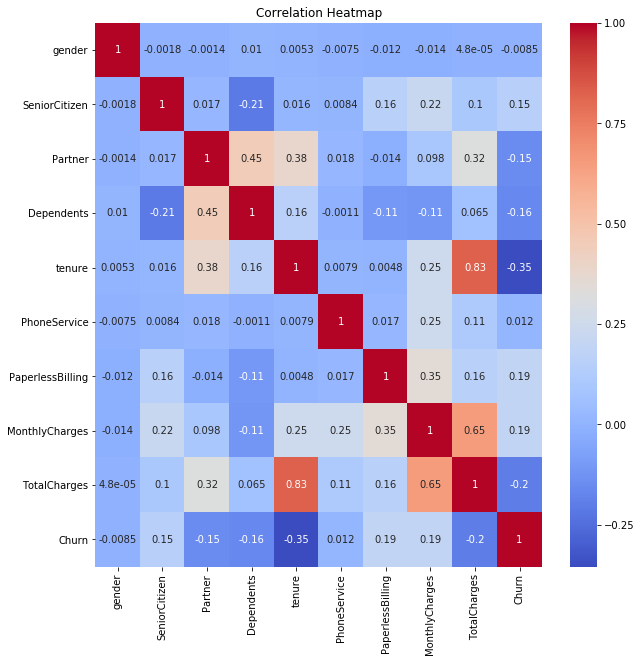

In [11]:
plt.subplots(figsize=(10,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, 
           cmap="coolwarm")
plt.show()

As we can see there are some features that are correlated while most are not at this point. Let's return to converting the remaining features. They are categorical with more than two categories. We will convert these to dummy variables introducing quite a few more features in the process.

In [12]:
# Convert features to dummy variables
df = pd.get_dummies(df)
df.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                

Ok, now that looks clean. Let's have another look at the correlations.

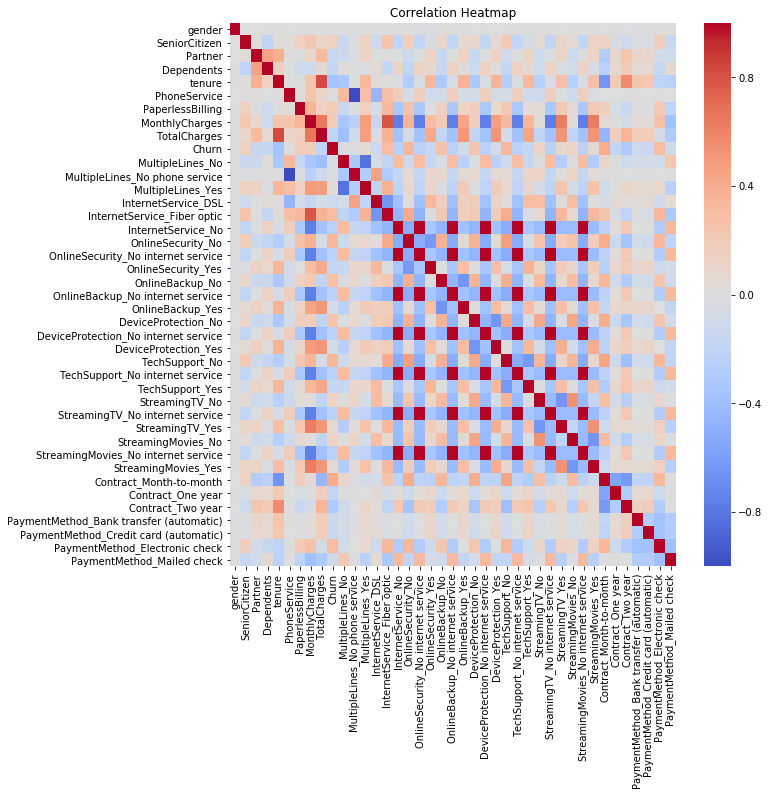

In [13]:
plt.subplots(figsize=(10,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=False, 
            cmap="coolwarm")
plt.show()

We can see that a number of features are basically duplicated as they all pertain to the customer not having internet service. Let's drop the duplicates.

In [14]:
cols = ['OnlineSecurity_No internet service',
        'OnlineBackup_No internet service',
        'DeviceProtection_No internet service',
        'TechSupport_No internet service',
        'StreamingTV_No internet service',
        'StreamingMovies_No internet service']
df = df.drop(columns=cols)

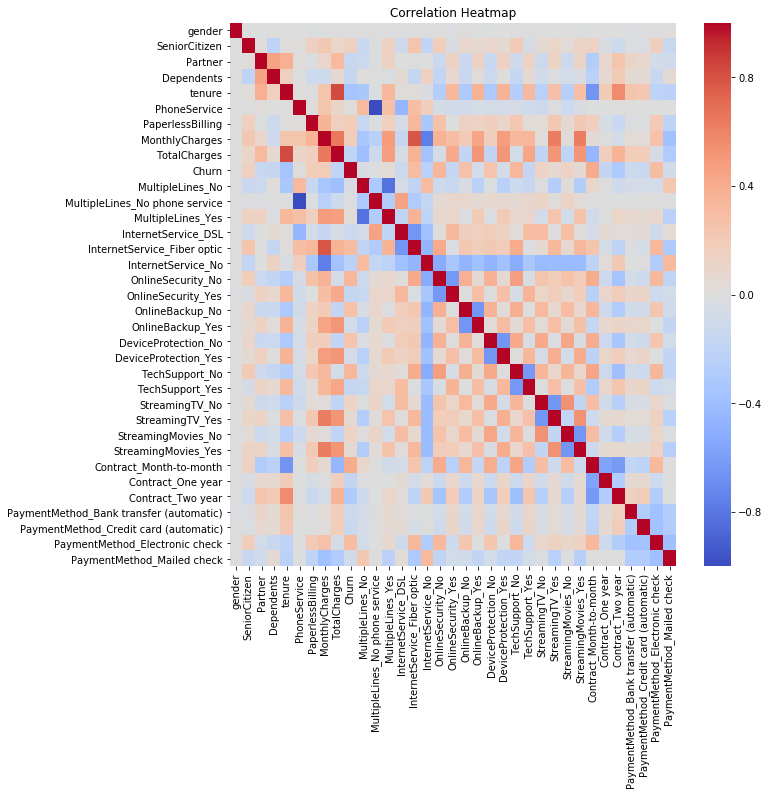

In [15]:
plt.subplots(figsize=(10,10))
ax = plt.axes()
ax.set_title("Correlation Heatmap")
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=False, 
            cmap="coolwarm")
plt.show()

That's better. We can see there are a few of higher correlating features. This is something to keep in mind for later and especially makes use of the naive bayes classifier unwise. Now we can split our features from the response variable creating a feature matrix and a response vector.

In [16]:
# Extract the 'Churn' column from the dataframe and convert to an array
y = df[['Churn']].values
y = np.reshape(df[['Churn']].values, len(y))
# Extract the feature coulmns from the dataframe and convert to a matrix array.
X = df.drop(columns='Churn').values

Before we run any models we should separate our data in a training set and a test set. We'll use 80% of our data for training.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)
print ("Number of training instances: ", len(X_train), "\nNumber of test instances: ", len(X_test))

Number of training instances:  5625 
Number of test instances:  1407


## k Nearest Neighbours
Let's try a simple classification algorithm first to see what we can get. We will use the k nearest neighbours model in this section.

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

In [18]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 1)
knn_model = knn.fit(X_train, y_train)
print('NN accuracy for train set: %f' % knn_model.score(X_train, y_train))
print('NN accuracy for test set: %f' % knn_model.score(X_test, y_test))

NN accuracy for train set: 0.998222
NN accuracy for test set: 0.722814


Unsurprisingly, our 1 nearest neighbour model drastically overfits the data, as can be seen by the big difference in train and test accuracies. Let's try cross validation to find an optimal k...

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

In [19]:
# Run a 10-fold cross validation
kfold = KFold(n_splits=10, random_state=0)

k = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43]
for i in k:
    KNN = neighbors.KNeighborsClassifier(n_neighbors = i)
    print("k={}: {}".format(i, round(cross_val_score(KNN, X_train, y_train, cv=kfold, scoring='accuracy').mean(),4)))

k=1: 0.7108
k=3: 0.7557
k=5: 0.7646
k=7: 0.7724
k=9: 0.7746
k=11: 0.7778
k=13: 0.7733
k=15: 0.7772
k=17: 0.7769
k=19: 0.7778
k=21: 0.7813
k=23: 0.7812
k=25: 0.7817
k=27: 0.7824
k=29: 0.7817
k=31: 0.7829
k=33: 0.7836
k=35: 0.7829
k=37: 0.781
k=39: 0.779
k=41: 0.7788
k=43: 0.778


Looks like we get the best results with a 33-nearest neighbours model. Let's refit and look at some performance metrics.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

In [20]:
KNN = neighbors.KNeighborsClassifier(n_neighbors = 33)
KNN.fit(X_train, y_train)
# Store the trainscore, testscore and prediction for later use
KNN_trainscore = KNN.score(X_train, y_train)
KNN_testscore = KNN.score(X_test, y_test)
KNN_cv_score = cross_val_score(KNN, X_train, y_train, cv=kfold, scoring='accuracy').mean()
KNN_prediction = KNN.predict(X_test)

In [21]:
def print_metrics(trainscore, testscore, cvscore, prediction, true_label):
    """
    This function prints the following performance metrics:
    """
    print('Train Accuracy: {:.4f}'.format(trainscore))
    print('Test Accuracy: {:.4f}'.format(testscore))
    print('10-fold Cross Validation Accuracy: {:.4f}\n'.format(cvscore))
    print('Precision: {:.4f}'.format(precision_recall_fscore_support(true_label, prediction)[0][0]))
    print('F1 Score: {:.4f}'.format(precision_recall_fscore_support(true_label, prediction)[2][0]))

In [22]:
print_metrics(KNN_trainscore, KNN_testscore, KNN_cv_score, KNN_prediction, y_test)

Train Accuracy: 0.7938
Test Accuracy: 0.7839
10-fold Cross Validation Accuracy: 0.7836

Precision: 0.8094
F1 Score: 0.8638


These are very pleasing results for the beginning. Let's plot a confusion matrix to make the performance of our model a little bit easier to understand.

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [23]:
def plot_confusion_matrix(prediction, true_label, normalize=False,
                          title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(true_label, prediction)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = title + " normalized"

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Yes', 'No'], rotation=45)
    plt.yticks(tick_marks, ['Yes', 'No'])

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

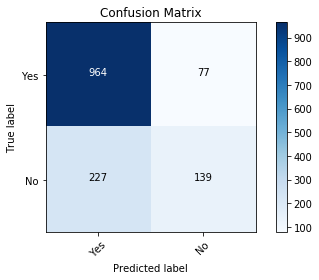

In [24]:
# Plot confusion matrix
plot_confusion_matrix(KNN_prediction, y_test)

We can clearly see how many instances were correctly and wrongly classified and in what way. Let's also look at Recall, Sensitivity, etc. in the next plot.

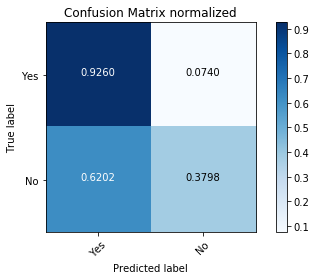

In [25]:
# Plot normalized confusion matrix
plot_confusion_matrix(KNN_prediction, y_test, normalize='TRUE')

Lastly let's try to plot the ROC curve for our model.

http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [26]:
def plot_roc_curve(true_label, prediction, probability, title='ROC Curve'):
    """
    This function prints and plots the ROC curve.
    """
    roc_auc = roc_auc_score(true_label, prediction)
    fpr, tpr, thresholds = roc_curve(true_label, probability[:,1])
    plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")

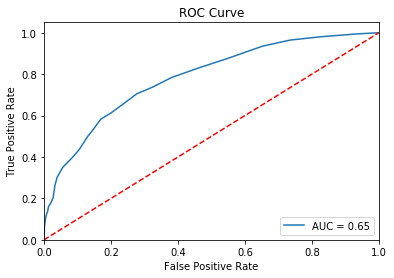

In [27]:
# Store the predicted values for later use
KNN_probability = KNN.predict_proba(X_test)

# Plot ROC curve
plot_roc_curve(y_test, KNN_prediction, KNN_probability)

We have all we need to look at some more interesting models and compare them.

## Logistic Regression
Let's look at one of the most popular binary classification algorithm and fit a logistic regression model to see what performance we get with it.

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [28]:
# Fit logreg model
LR = LogisticRegression(penalty='l2', random_state=17)
LR.fit(X_train, y_train)

# Store the trainscore, testscore and prediction for later use
LR_trainscore = LR.score(X_train, y_train)
LR_testscore = LR.score(X_test, y_test)
LR_cv_score = cross_val_score(LR, X_train, y_train, cv=kfold, scoring='accuracy').mean()
LR_prediction = LR.predict(X_test)
LR_probability = LR.predict_proba(X_test)

print_metrics(LR_trainscore, LR_testscore, LR_cv_score, LR_prediction, y_test)

Train Accuracy: 0.8082
Test Accuracy: 0.8053
10-fold Cross Validation Accuracy: 0.8050

Precision: 0.8490
F1 Score: 0.8720


Not bad. There seems to be no sign of overfitting. Maybe we can reduce the regularization a bit to reduce bias.

In [29]:
# Fit logreg model
LR = LogisticRegression(penalty='l2', random_state=17, C=9999999999999999999)
LR.fit(X_train, y_train)

# Store the trainscore, testscore and prediction for later use
LR_trainscore = LR.score(X_train, y_train)
LR_testscore = LR.score(X_test, y_test)
LR_cv_score = cross_val_score(LR, X_train, y_train, cv=kfold, scoring='accuracy').mean()
LR_prediction = LR.predict(X_test)
LR_probability = LR.predict_proba(X_test)

print_metrics(LR_trainscore, LR_testscore, LR_cv_score, LR_prediction, y_test)

Train Accuracy: 0.8084
Test Accuracy: 0.8038
10-fold Cross Validation Accuracy: 0.8043

Precision: 0.8474
F1 Score: 0.8711


That barely had any effect. So no overfitting even with barely any regularization. Let's try standardizing the data.

https://www.kaggle.com/lilyelizabethjohn/standardization-using-standardscaler

In [30]:
#Standardization
sc=StandardScaler()
X_train_std=sc.fit_transform(X_train)
X_test_std=sc.transform(X_test)

In [31]:
# Fit logreg model
LR = LogisticRegression(penalty='l1', random_state=17, C=9999999999999999999)
LR.fit(X_train_std, y_train)

# Store the trainscore, testscore and prediction for later use
LR_trainscore = LR.score(X_train_std, y_train)
LR_testscore = LR.score(X_test_std, y_test)
LR_cv_score = cross_val_score(LR, X_train_std, y_train, cv=kfold, scoring='accuracy').mean()
LR_prediction = LR.predict(X_test_std)
LR_probability = LR.predict_proba(X_test_std)

print_metrics(LR_trainscore, LR_testscore, LR_cv_score, LR_prediction, y_test)

Train Accuracy: 0.8082
Test Accuracy: 0.8024
10-fold Cross Validation Accuracy: 0.8044

Precision: 0.8471
F1 Score: 0.8701


Also no significant effect. Let's try Lasso Regularization instead. This should be better with the large amounts of correlating features.

In [32]:
# Fit logreg model
LR = LogisticRegression(penalty='l1', random_state=17, C=9999999999999999999)
LR.fit(X_train, y_train)

# Store the trainscore, testscore and prediction for later use
LR_trainscore = LR.score(X_train, y_train)
LR_testscore = LR.score(X_test, y_test)
LR_cv_score = cross_val_score(LR, X_train, y_train, cv=kfold, scoring='accuracy').mean()
LR_prediction = LR.predict(X_test)
LR_probability = LR.predict_proba(X_test)

print_metrics(LR_trainscore, LR_testscore, LR_cv_score, LR_prediction, y_test)

Train Accuracy: 0.8089
Test Accuracy: 0.8024
10-fold Cross Validation Accuracy: 0.8053

Precision: 0.8465
F1 Score: 0.8702


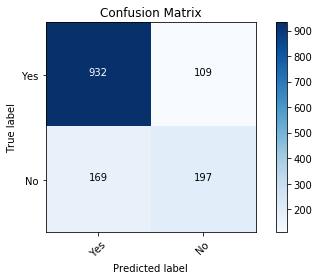

In [33]:
plot_confusion_matrix(LR_prediction, y_test)

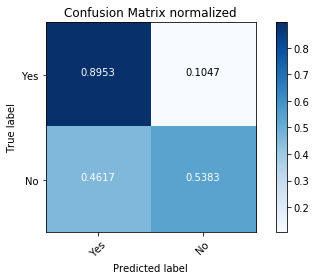

In [34]:
plot_confusion_matrix(LR_prediction, y_test, normalize='TRUE')

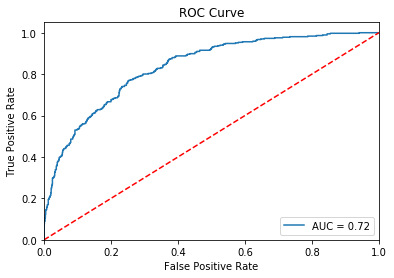

In [35]:
plot_roc_curve(y_test, LR_prediction, LR_probability)

We have improved slighlty over the knn model, but there is not much more we can do with logistic regression, as even with a ridiculously high regularization budget C the model still doesn't overfit.

## Decision Tree
Let's have a luck at the decision tree model to see what performance we get with it.

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [36]:
# Fit decision tree model
DT = DecisionTreeClassifier(criterion='gini', random_state=17)
DT.fit(X_train, y_train)

# Store the trainscore, testscore and prediction for later use
DT_trainscore = DT.score(X_train, y_train)
DT_testscore = DT.score(X_test, y_test)
DT_cv_score = cross_val_score(DT, X_train, y_train, cv=kfold, scoring='accuracy').mean()
DT_prediction = DT.predict(X_test)
DT_probability = DT.predict_proba(X_test)
    
print_metrics(DT_trainscore, DT_testscore, DT_cv_score, DT_prediction, y_test)

Train Accuracy: 0.9982
Test Accuracy: 0.7228
10-fold Cross Validation Accuracy: 0.7266

Precision: 0.8151
F1 Score: 0.8120


Serious case of overfitting here. Let's try limiting the tree depth to various values.

In [37]:
for i in range(1,9):

    # Fit decision tree model
    DT = DecisionTreeClassifier(criterion='gini', random_state=17, max_depth=i)
    DT.fit(X_train, y_train)

    print("max_depth={}: {}".format(i, cross_val_score(DT, X_train, y_train, cv=kfold, scoring='accuracy').mean()))

max_depth=1: 0.7327980506058672
max_depth=2: 0.7599909609805124
max_depth=3: 0.7884379562966568
max_depth=4: 0.7950181096439384
max_depth=5: 0.7959074733096084
max_depth=6: 0.7889765048703248
max_depth=7: 0.7857736578952358
max_depth=8: 0.7763556948983269


A max depth of 5 seems like the optimal choice. Let's see if anything changes by choosing the entropy approach.

In [38]:
for i in range(1,9):

    # Fit decision tree model
    DT = DecisionTreeClassifier(criterion='entropy', random_state=17, max_depth=i)
    DT.fit(X_train, y_train)

    print("max_depth={}: {}".format(i, cross_val_score(DT, X_train, y_train, cv=kfold, scoring='accuracy').mean()))

max_depth=1: 0.7327980506058672
max_depth=2: 0.7599909609805124
max_depth=3: 0.7895055719550198
max_depth=4: 0.7959081054088734
max_depth=5: 0.795907789359241
max_depth=6: 0.7859509617390316
max_depth=7: 0.7832853991390809
max_depth=8: 0.7800869768588459


Same story here. Let's refit and look at some performance metrics.

In [39]:
# Fit decision tree model
DT = DecisionTreeClassifier(criterion='entropy', random_state=17, max_depth=5)
DT.fit(X_train, y_train)

# Store the trainscore, testscore and prediction for later use
DT_trainscore = DT.score(X_train, y_train)
DT_testscore = DT.score(X_test, y_test)
DT_cv_score = cross_val_score(DT, X_train, y_train, cv=kfold, scoring='accuracy').mean()
DT_prediction = DT.predict(X_test)
DT_probability = DT.predict_proba(X_test)
    
print_metrics(DT_trainscore, DT_testscore, DT_cv_score, DT_prediction, y_test)

Train Accuracy: 0.8046
Test Accuracy: 0.7797
10-fold Cross Validation Accuracy: 0.7959

Precision: 0.8464
F1 Score: 0.8521


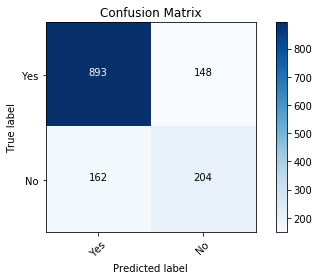

In [40]:
plot_confusion_matrix(DT_prediction, y_test)

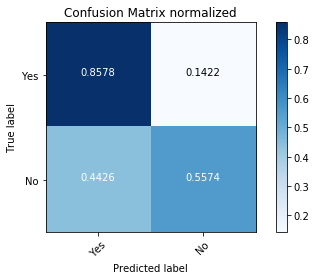

In [41]:
plot_confusion_matrix(DT_prediction, y_test, normalize='TRUE')

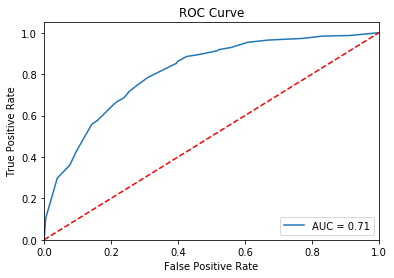

In [42]:
plot_roc_curve(y_test, DT_prediction, DT_probability)

It's rather disappointing that this model does not improve on our logistic regression. We'll look into improving this with ensemble methods next.

## Ensemble Methods
Let's see if we can improve the performance on our decision tree, starting with bagging.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

In [43]:
# Fit bagging model on decision trees of the same max_depth
BA = BaggingClassifier(DecisionTreeClassifier(criterion='entropy', random_state=17, max_depth=5), random_state=17, n_jobs=-1)
BA.fit(X_train, y_train)

# Store the trainscore, testscore and prediction for later use
BA_trainscore = BA.score(X_train, y_train)
BA_testscore = BA.score(X_test, y_test)
BA_cv_score = cross_val_score(BA, X_train, y_train, cv=kfold, scoring='accuracy').mean()
BA_prediction = BA.predict(X_test)
BA_probability = BA.predict_proba(X_test)
    
print_metrics(BA_trainscore, BA_testscore, BA_cv_score, BA_prediction, y_test)

Train Accuracy: 0.8084
Test Accuracy: 0.7925
10-fold Cross Validation Accuracy: 0.8020

Precision: 0.8305
F1 Score: 0.8657


Better, but still short of logistic regression. Let's try random forests.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [44]:
# Fit decision tree model
RF = RandomForestClassifier(criterion='entropy', max_depth=5, random_state=17)
RF.fit(X_train, y_train)

# Store the trainscore, testscore and prediction for later use
RF_trainscore = RF.score(X_train, y_train)
RF_testscore = RF.score(X_test, y_test)
RF_cv_score = cross_val_score(RF, X_train, y_train, cv=kfold, scoring='accuracy').mean()
RF_prediction = RF.predict(X_test)
RF_probability = RF.predict_proba(X_test)
    
print_metrics(RF_trainscore, RF_testscore, RF_cv_score, RF_prediction, y_test)

Train Accuracy: 0.8060
Test Accuracy: 0.7953
10-fold Cross Validation Accuracy: 0.7948

Precision: 0.8265
F1 Score: 0.8687


No improvement here. Let's try Adaboost.

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [45]:
# Fit decision tree model
ADA = AdaBoostClassifier(random_state=17)
ADA.fit(X_train, y_train)

# Store the trainscore, testscore and prediction for later use
ADA_trainscore = ADA.score(X_train, y_train)
ADA_testscore = ADA.score(X_test, y_test)
ADA_cv_score = cross_val_score(ADA, X_train, y_train, cv=kfold, scoring='accuracy').mean()
ADA_prediction = ADA.predict(X_test)
ADA_probability = ADA.predict_proba(X_test)
    
print_metrics(ADA_trainscore, ADA_testscore, ADA_cv_score, ADA_prediction, y_test)

Train Accuracy: 0.8085
Test Accuracy: 0.7974
10-fold Cross Validation Accuracy: 0.8082

Precision: 0.8393
F1 Score: 0.8677


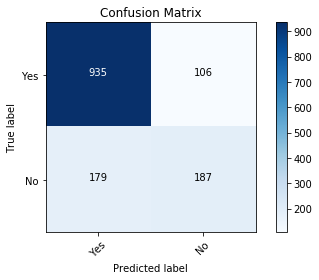

In [46]:
plot_confusion_matrix(ADA_prediction, y_test)

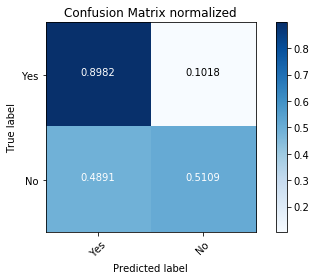

In [47]:
plot_confusion_matrix(ADA_prediction, y_test, normalize='TRUE')

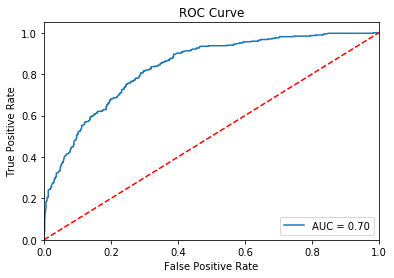

In [48]:
plot_roc_curve(y_test, ADA_prediction, ADA_probability)

A very slight improvement here. There seems to be a pattern here. No matter what we try our performance stays in this region for the data that we have.

## Feature Importance
Let's use the power of the random forest model quickly to review our features and calculate their importance.

http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

Feature ranking:
1. Contract_Month-to-month (0.175761)
2. tenure (0.122279)
3. Contract_Two year (0.116219)
4. InternetService_Fiber optic (0.111420)
5. OnlineSecurity_No (0.078200)
6. TotalCharges (0.066942)
7. OnlineBackup_No (0.059835)
8. PaymentMethod_Electronic check (0.045752)
9. Contract_One year (0.031880)
10. DeviceProtection_No (0.031095)
11. TechSupport_No (0.029701)
12. MonthlyCharges (0.022841)
13. PaperlessBilling (0.020056)
14. InternetService_DSL (0.015451)
15. OnlineBackup_Yes (0.013684)
16. TechSupport_Yes (0.008444)
17. SeniorCitizen (0.008416)
18. Partner (0.004713)
19. MultipleLines_No phone service (0.004588)
20. StreamingTV_Yes (0.004305)
21. StreamingMovies_Yes (0.004268)
22. OnlineSecurity_Yes (0.004200)
23. InternetService_No (0.004137)
24. Dependents (0.002580)
25. StreamingTV_No (0.002306)
26. DeviceProtection_Yes (0.001979)
27. MultipleLines_Yes (0.001663)
28. gender (0.001583)
29. PaymentMethod_Mailed check (0.001312)
30. MultipleLines_No (0.001121)
31. Ph

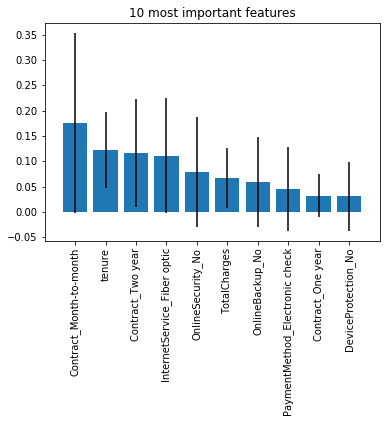

In [49]:
importances = RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, df.drop(columns='Churn').columns[indices[f]], importances[indices[f]]))

# Plot the 12 most important features of the forest
indices = indices[:10]
plt.figure()
plt.title("10 most important features")
plt.bar(range(10), importances[indices],
        yerr=std[indices], align="center")
plt.xticks(range(10), df.drop(columns='Churn').columns[indices], rotation=90)
plt.xlim([-1, 10])
plt.show()

Unsurprisingly a lot of our many features are quite unimportant. The first 10 might be the interesting ones although it's not easy justifying their importance without further knowledge.

## Summary
Let's get an overlook of our models performances to show that trying more and more models probably isn't going to get us any further.

In [50]:
print(15*'-', 'Test Scores 33 Nearest Neighbours', 15*'-', '\n')
print('Test accuracy: {:.4f}'.format(KNN_testscore))
print('10-fold Cross Validation Accuracy: {:.4f}\n'.format(KNN_cv_score))

print(15*'-', 'Test Scores Logistic Regression', 15*'-', '\n')
print('Test accuracy: {:.4f}'.format(LR_testscore))
print('10-fold Cross Validation Accuracy: {:.4f}\n'.format(LR_cv_score))

print(15*'-', 'Test Scores Decision Tree', 15*'-', '\n')
print('Test accuracy: {:.4f}'.format(DT_testscore))
print('10-fold Cross Validation Accuracy: {:.4f}\n'.format(DT_cv_score))

print(15*'-', 'Test Scores Bagging', 15*'-', '\n')
print('Test accuracy: {:.4f}'.format(BA_testscore))
print('10-fold Cross Validation Accuracy: {:.4f}\n'.format(BA_cv_score))

print(15*'-', 'Test Scores Random Forest', 15*'-', '\n')
print('Test accuracy: {:.4f}'.format(RF_testscore))
print('10-fold Cross Validation Accuracy: {:.4f}\n'.format(RF_cv_score))

print(15*'-', 'Test Scores Adaboost', 15*'-', '\n')
print('Test accuracy: {:.4f}'.format(ADA_testscore))
print('10-fold Cross Validation Accuracy: {:.4f}\n'.format(ADA_cv_score))

--------------- Test Scores 33 Nearest Neighbours --------------- 

Test accuracy: 0.7839
10-fold Cross Validation Accuracy: 0.7836

--------------- Test Scores Logistic Regression --------------- 

Test accuracy: 0.8024
10-fold Cross Validation Accuracy: 0.8053

--------------- Test Scores Decision Tree --------------- 

Test accuracy: 0.7797
10-fold Cross Validation Accuracy: 0.7959

--------------- Test Scores Bagging --------------- 

Test accuracy: 0.7925
10-fold Cross Validation Accuracy: 0.8020

--------------- Test Scores Random Forest --------------- 

Test accuracy: 0.7953
10-fold Cross Validation Accuracy: 0.7948

--------------- Test Scores Adaboost --------------- 

Test accuracy: 0.7974
10-fold Cross Validation Accuracy: 0.8082

